## Introduction

Back in 2018 I worked as a quantum error correction researcher at the University of Basel. IBM had just put a 16 qubit device online, and I wanted to see how well it could implement the basics of QEC. So I ran repetition codes.


* *James R. Wootton and Daniel Loss Phys. Rev. A 97, 052313 (2018)*

The main aim was to run codes of varying sizes, to test the idea that logical errors are suppressed with increasng code size. Here are the results from that 16 qubit device, which at that time was called *ibmqx3*.

<img src="images/ibmqx3-decay.png" alt="" width="700"/>

Here the points show the probability of a logical error for different codes. The *partial decoding* is a simple majority voting of the final results of the code qubits. The *full decoding* takes the full set of results into account.

The points here decrease in a manner that is a but bumpy, but largely linear. Note that the y axis is logarithmic. The results are therefore consistent with the logical error decreasing exponentially with code size.




After a few months, the device was taken out of the fridge for a while and cooled down again. It's name changed to *ibmqx5* and its behaviour changed also.

<img src="images/ibmqx5-decay.png" alt="" width="700"/>

Note the uptick of the partial decoding, which shows that something is not right.

To see what is going on, we can look at a different kind of graph. For each qubit, what is the probability that it ends up in the `1` state?

For *ibmqx3*, the results looked like the following.

<img src="images/ibmqx3-1.png" alt="" width="900"/>

As more qubits are added in to the code, more get affected by the additional noise. But for those already in the code, the noise they experience appears to be the same. This is what we might expect from the repetition code, since the circuit experienced by any qubit is not affected by qubits far away.

Now let's take a look at *ibmqx5* instead.

<img src="images/ibmqx5-1.png" alt="" width="910"/>

In going from `d=7` to `d=8`, qubits 13 and 14 are added to the code. But the effects go far beyond just these. Many qubits are hit with a huge amount of noise, all the way down to qubit 9.

This is what causes the uptick seen earlier, where increasing code size does not lead to less logical errors. It shows that the method used to make this device is not good enough to support large-scale quantum error correction. Because of problems such as this, IBM rethought how they arranged their qubits. And it was independently discovered by me, an external researcher running repetition codes.

So what remains for us to discover in 2021?

## Repetiton codes with Qiskit

Now let's make some repetition codes with Qiskit. We'll need `QuantumCircuit` objects, and `QuantumRegister` and `ClassicalRegister` objects.

In [12]:
%matplotlib

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

Using matplotlib backend: MacOSX


We'll also need too decide how big we want the code to be. Specifcially, the number of repetitions `d` and the number of syndrome measurement rounds `T`.

To be able to see the circuits easily, we'll start with the minimum for `d`.

In [13]:
d = 3

Let's also increase the value of `T` as we add measurement rounds to the circuit. So since we start with none...

In [14]:
T = 0

We start with an empty circuit

In [15]:
qc = QuantumCircuit()

then we add `d` code qubits

In [16]:
code_qubit = QuantumRegister(d, 'code_qubit')
qc.add_register( code_qubit )

and `d-1` auxilliary qubits.

In [17]:
link_qubit = QuantumRegister(d-1, 'link_qubit')
qc.add_register( link_qubit )

Then what we have is a `d=3`, `T=0` code for an encoded logical `0`. Which is still basically an empty circuit.

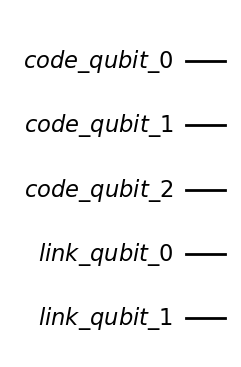

In [18]:
qc.draw(output='mpl')

Now we can add the `cx` gates required for each syndrome measurement round. Each time this cell is run, it iterates `T` by 1.

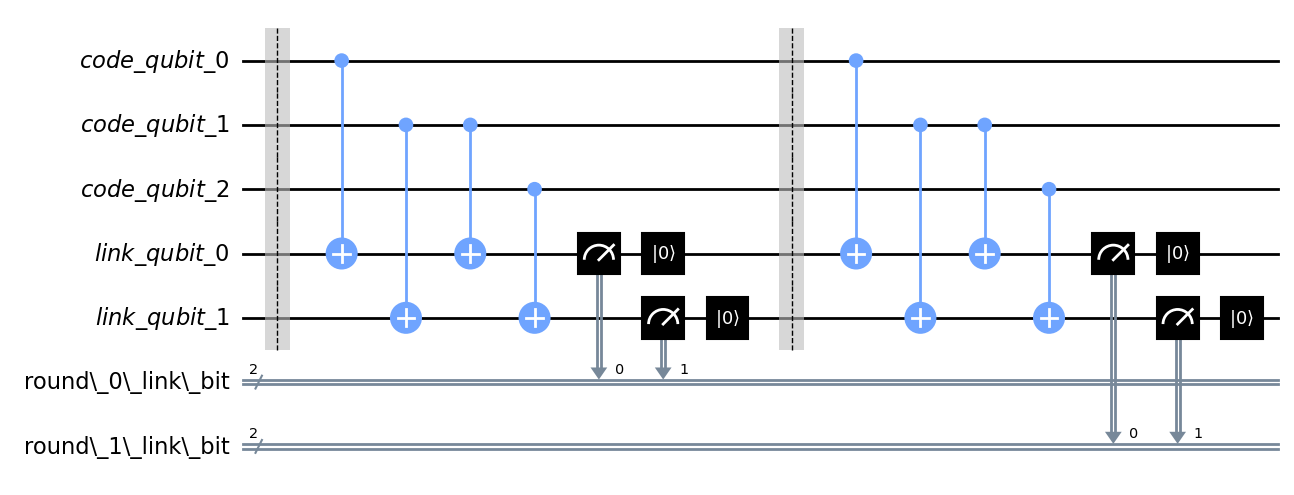

In [21]:
qc.barrier()

# for each link qubit, add a cx for the code qubit on one side
for j in range(d-1):
    qc.cx(code_qubit[j],link_qubit[j])
        
# and then one for the other side
for j in range(d-1):
    qc.cx(code_qubit[j+1],link_qubit[j])
    
# add a classical register to hold results from this round
link_bit = ClassicalRegister(d-1, 'round_'+str(T)+'_link_bit')
qc.add_register(link_bit)

# measure and then rest each link qubit to extract the syndrome
for j in range(d-1):
    qc.measure(link_qubit[j],link_bit[j])
    qc.reset(link_qubit[j])
        
# iterate the number of rounds
T += 1
    
qc.draw(output='mpl') # uncomment to draw circuit

Then we add the final readout of the code qubits.

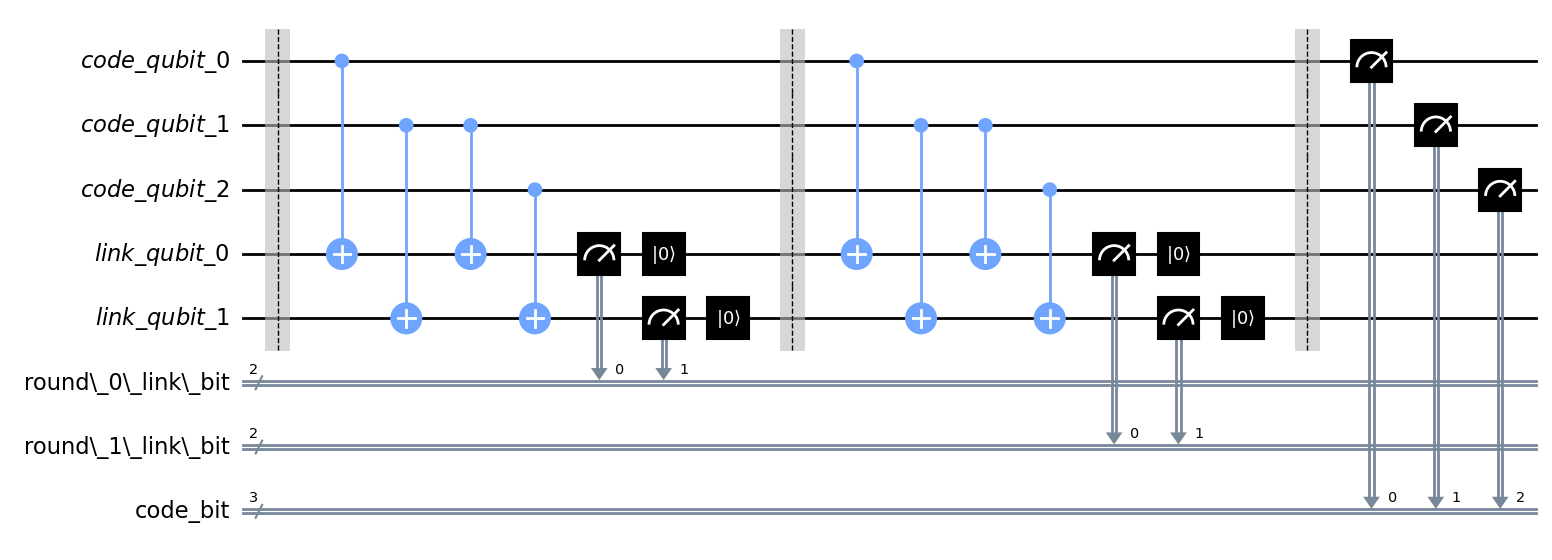

In [22]:
qc.barrier()

# add d bits for final readout of code qubits
code_bit = ClassicalRegister(d, 'code_bit')
qc.add_register(code_bit)

# measure code qubits
for j in range(d):
    qc.measure(code_qubit[j],code_bit[j])
    
qc.draw(output='mpl') # uncomment to draw circuit

Now we have a code, we need a backend to run it on. We'll start with just a simulator.

In [23]:
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')

In [24]:
job = backend.run(qc)
counts = job.result().get_counts()

In [25]:
counts

{'000 00 00': 1024}

In [1]:
from qiskit.ignis.verification.topological_codes import RepetitionCode

In [2]:
code = RepetitionCode(3,2)

In [6]:
code.circuit['0'].qregs

[QuantumRegister(2, 'link_qubit'), QuantumRegister(3, 'code_qubit')]

In [7]:
code.circuit['0'].cregs

[ClassicalRegister(2, 'round_0_link_bit'),
 ClassicalRegister(2, 'round_1_link_bit'),
 ClassicalRegister(3, 'code_bit')]

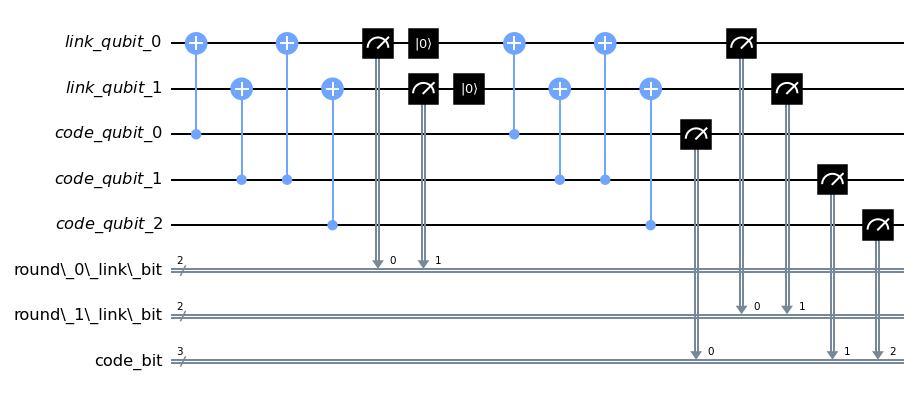

In [22]:
code.circuit['0'].draw(output='mpl')

{'000 00 10': 1024}

In [291]:
qc.cregs

[ClassicalRegister(2, 'round_0_link_bit'),
 ClassicalRegister(2, 'round_1_link_bit'),
 ClassicalRegister(3, 'code_bit')]

In [285]:
with open('examples.p','rb') as file:
    examples = pickle.load(file)

{'001 01 01': 1024}


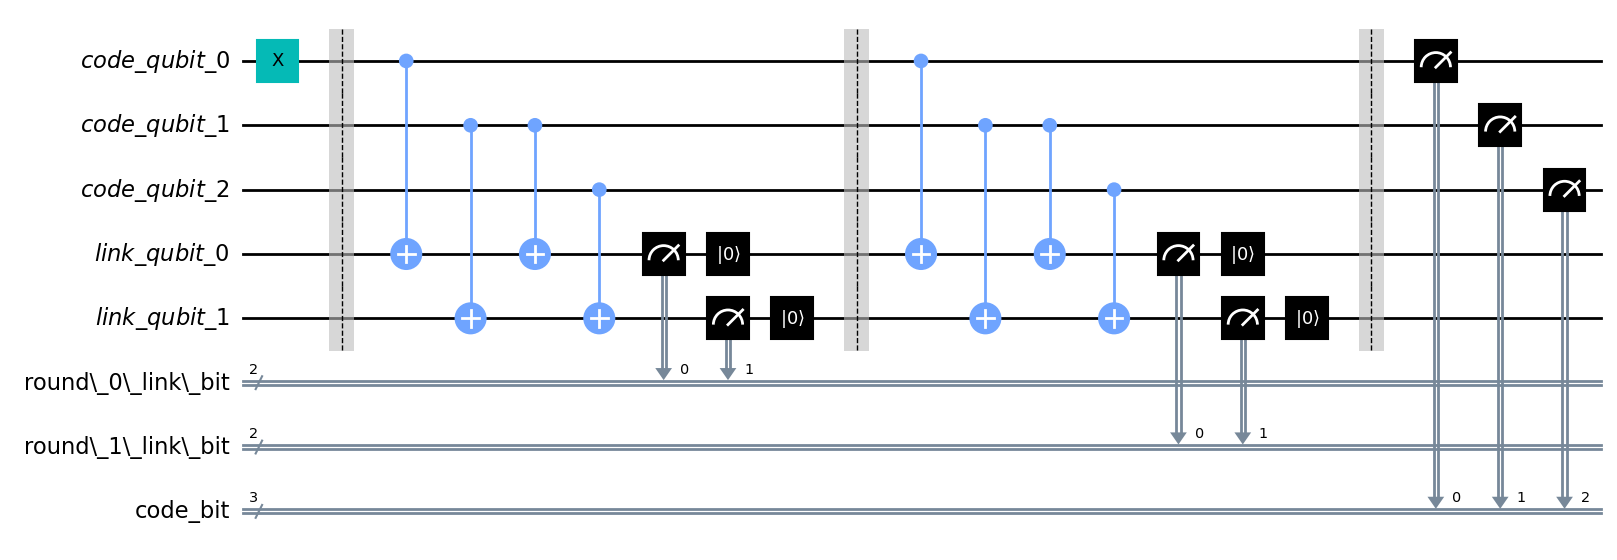

In [301]:
example = examples[0]
    
example.draw(output='mpl')

job = backend.run(example)
counts = job.result().get_counts()
print(counts)

In [314]:
def process_output_1(output):
    
    output = output.split(' ')
    
    logical = output[0][0]+' '+output[0][-1]

    final = ''
    for j in range(d-1):
        if output[0][j]==output[0][j+1]:
            final += '0'
        else:
            final += '1'
    output[0] = final     
    
    output = logical + '  ' + ' '.join(output)
    
    return output

process_output_1('010 01 01')

'0 0  11 01 01'